In [1]:
! hostname
! whoami
! pwd
# ! nvidia-smi

Akarshs-MacBook-Pro.local
akarshkumar0101
/Users/akarshkumar0101/exploration-generalization/atari


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run imports.py

In [4]:
env = make_env("MontezumaRevenge", n_envs=64)
obsi, info = env.reset()
obs = [obsi[:, -1]]

for i in tqdm(range(1024)):
    obsi, rew, term, trunc, info = env.step(env.action_space.sample())
    obs.append(obsi[:, -1])

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


  0%|          | 0/1024 [00:00<?, ?it/s]

In [5]:
obs = torch.as_tensor(np.stack(obs))

In [7]:
n_steps = 1000
batch_size = 256
lr = 3e-4
device = "mps"

In [10]:
encoder = Encoder((1, 84, 84), 64).to(device)
opt = torch.optim.Adam(encoder.parameters(), lr=lr)

losses = []
pbar = tqdm(range(n_steps))
for i_step in pbar:
    obs_anc, obs_pos, obs_neg = sample_contrastive_batch(obs, 0.1, batch_size=batch_size)
    obs_anc, obs_pos, obs_neg = obs_anc.to(device), obs_pos.to(device), obs_neg.to(device)

    loss = calc_contrastive_loss(encoder, obs_anc, obs_pos, obs_neg)

    opt.zero_grad()
    loss.backward()
    opt.step()

    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())



  0%|          | 0/1000 [00:00<?, ?it/s]

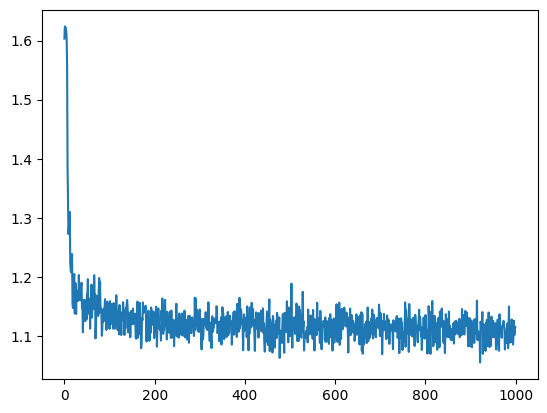

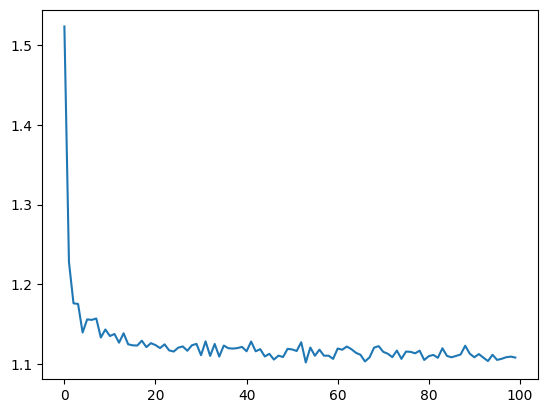

In [18]:
plt.plot(losses)
plt.show()
plt.plot(np.array(losses).reshape(-1, 10).mean(axis=-1))
plt.show()

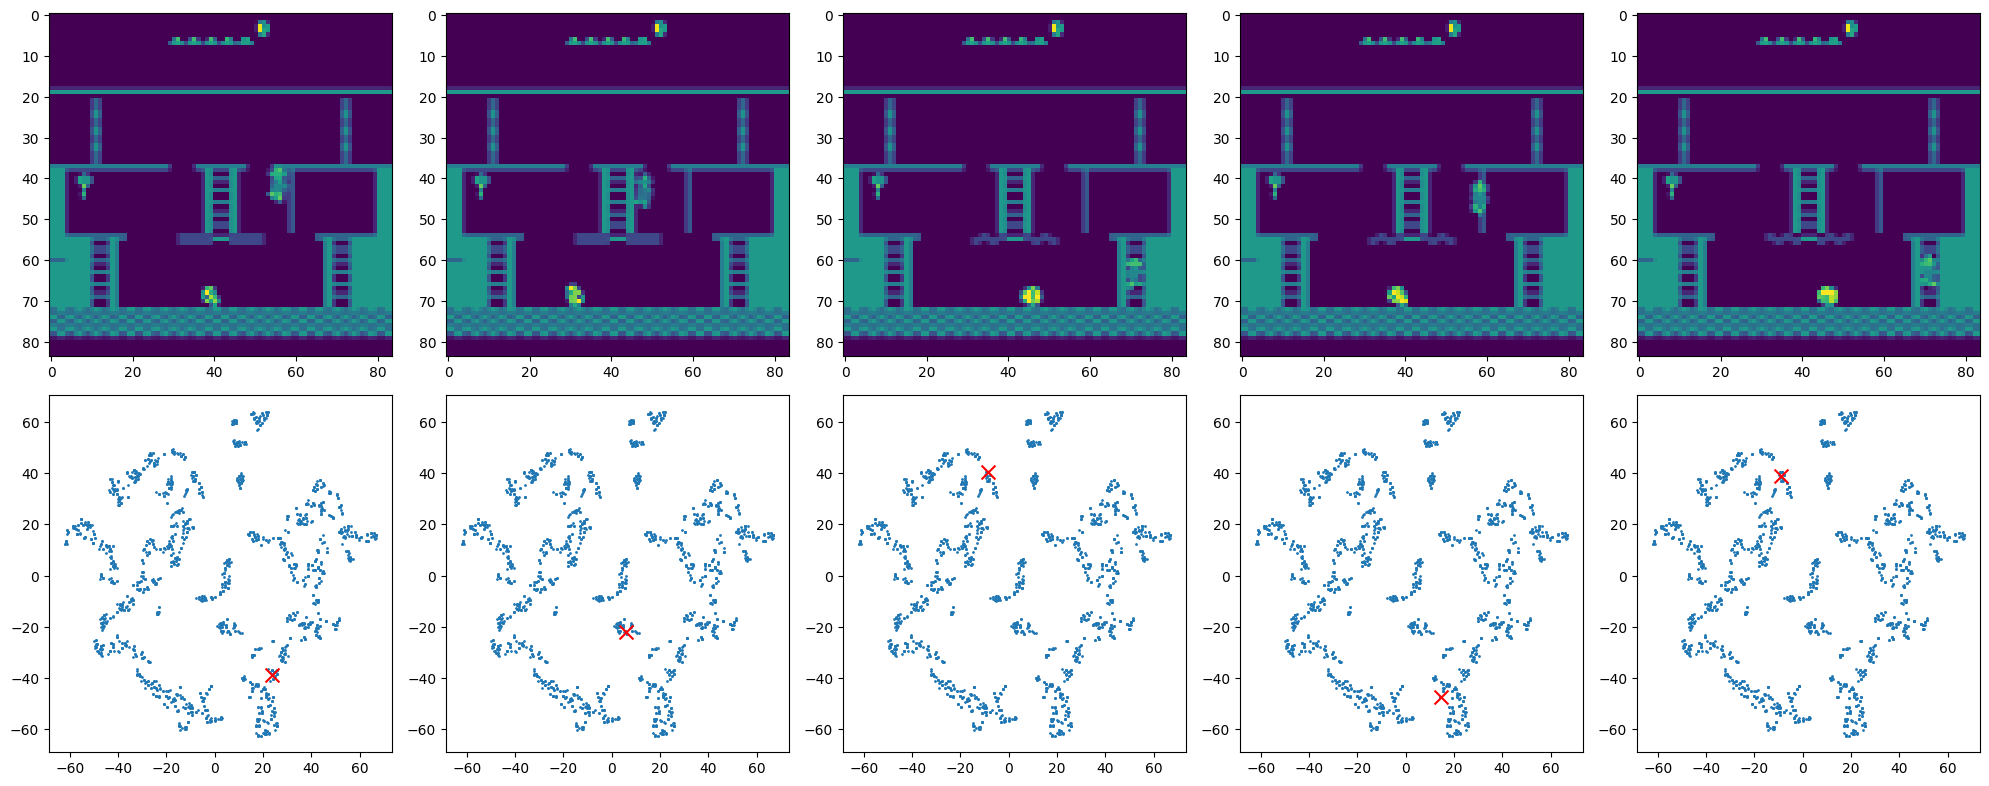

In [29]:
i_env = torch.randint(0, 8, (2048,))
i_step = torch.randint(0, 128, (2048,))
o = obs[i_step, i_env].to(device)

with torch.no_grad():
    latent = encoder.encode(o[:, None])
X = latent.cpu().detach().numpy()

import sklearn.manifold
tsne = sklearn.manifold.TSNE()
X2D = tsne.fit_transform(X)

plt.figure(figsize=(20, 8))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(o[i].cpu().detach().numpy())
    plt.subplot(2, 5, i + 1 + 5)
    # plt.scatter(X2D[[i], 0], X2D[[i], 1])
    plt.scatter(*X2D.T, s=1.0)
    plt.scatter(*X2D[[i], :].T, s=100.0, c="r", marker="x")
    # plt.xlim(-3, 3); plt.ylim(-3, 3)
plt.tight_layout()
plt.show()

In [112]:
o = obs[:32, :32].to(device)

with torch.no_grad():
    latent = encoder.encode(rearrange(o, 't n h w -> (t n) 1 h w'))
X = latent.cpu().detach().numpy()

import sklearn.manifold
tsne = sklearn.manifold.TSNE()
X2D = tsne.fit_transform(X)
X2D = X2D.reshape(32, 32, 2)



In [113]:
o.shape

torch.Size([32, 32, 84, 84])

In [114]:
img = np.zeros((32, 84, 84, 3))
w_green = np.linspace(0, 1, 32).reshape(32, 1, 1, 1)
w_red = 1.-w_green
img[:, :, :, 0] = (o.cpu().numpy()/255.*w_red).max(axis=0)
img[:, :, :, 1] = (o.cpu().numpy()/255.*w_green).max(axis=0)

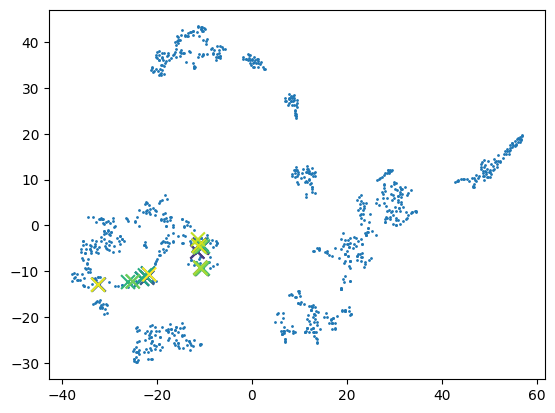

In [124]:
plt.scatter(*X2D.reshape(-1, 2).T, s=1.)
plt.scatter(*X2D[0, :].T, s=100., marker='x', c=np.arange(32))
plt.show()

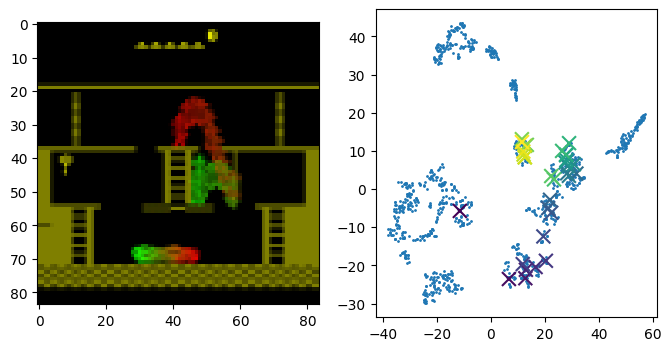

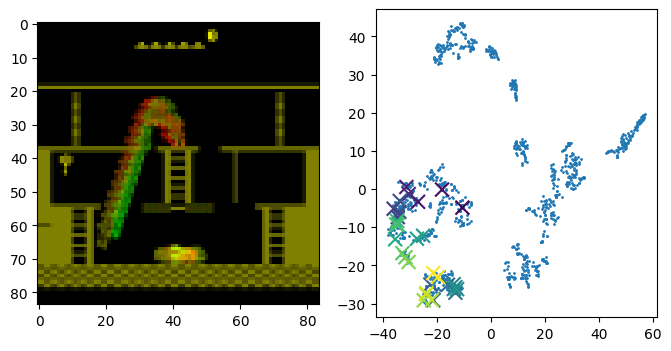

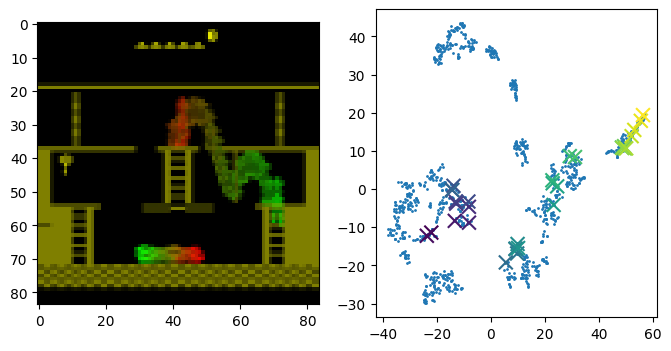

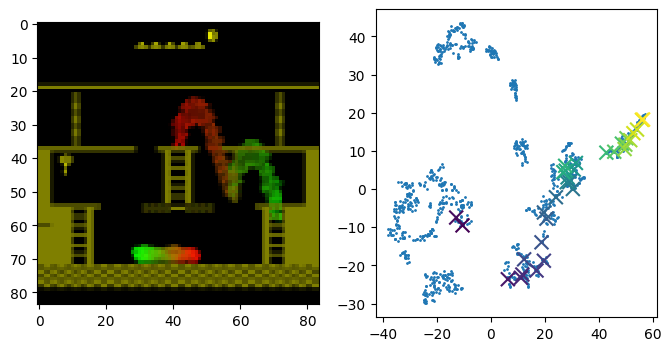

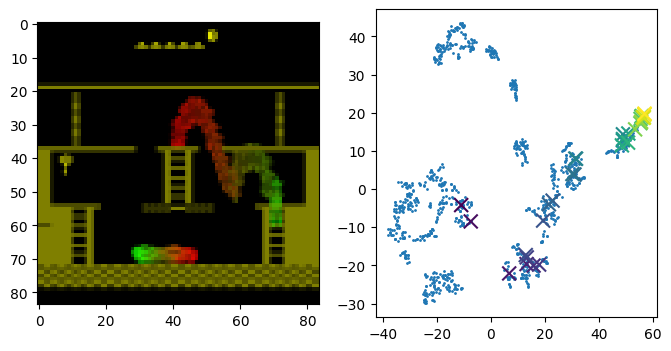

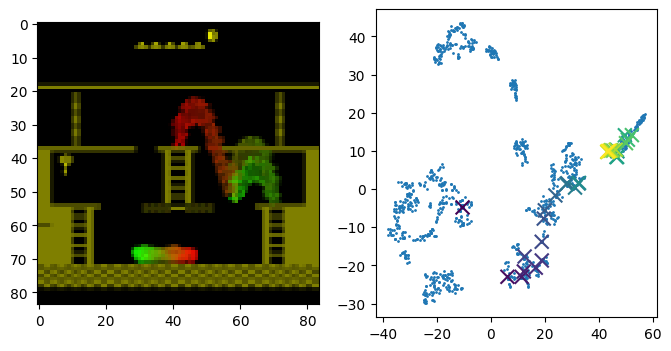

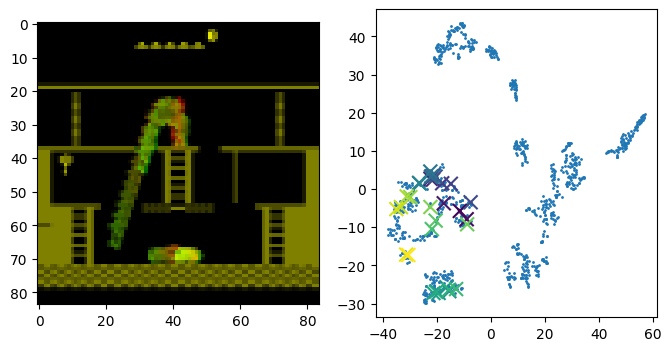

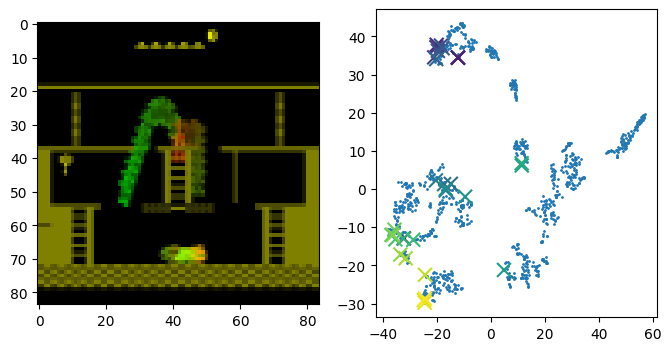

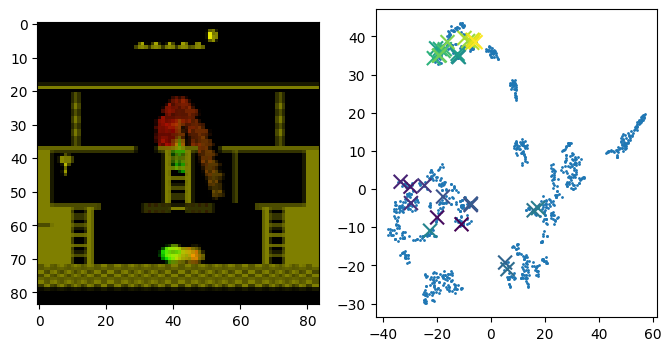

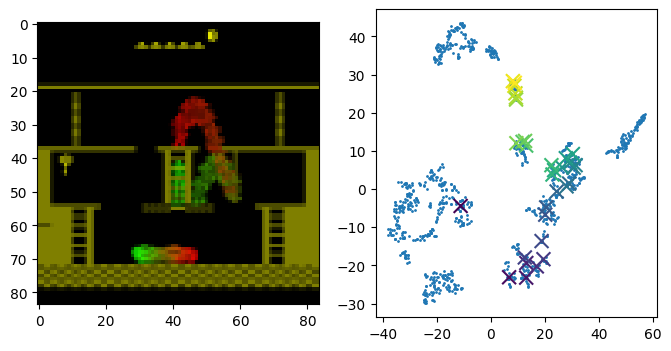

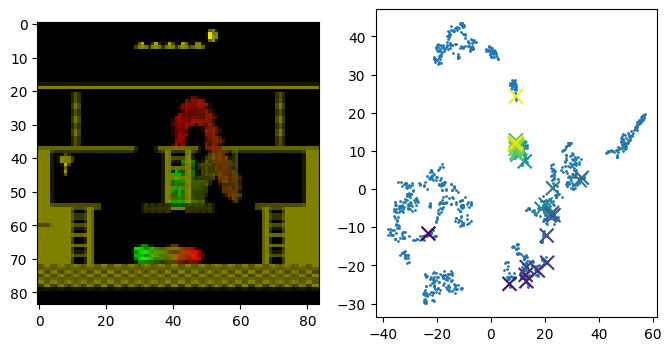

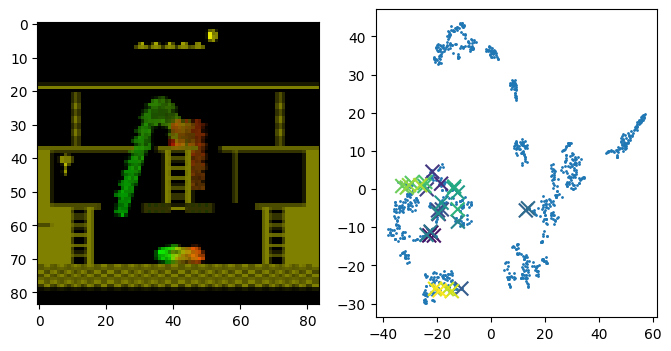

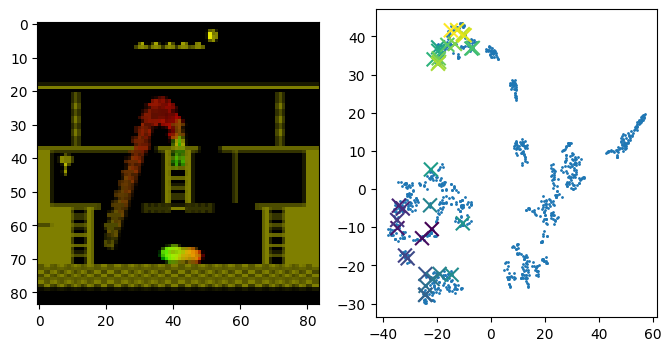

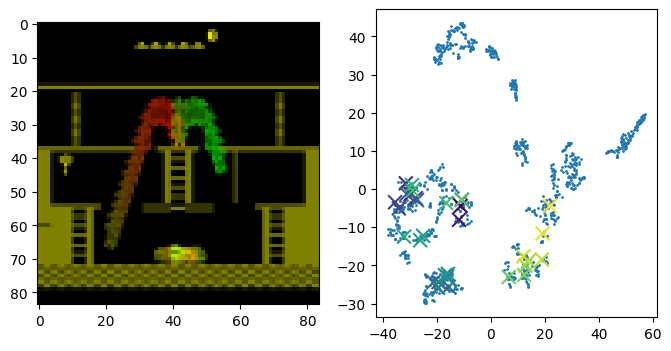

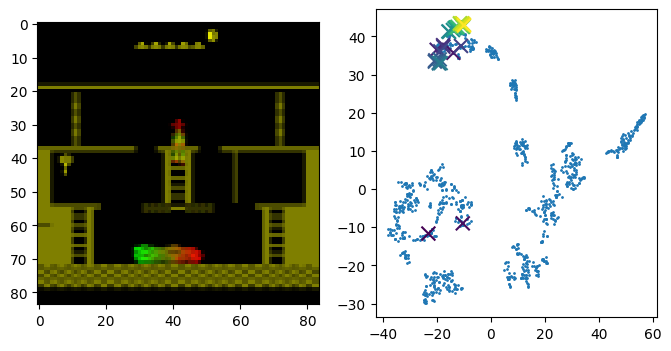

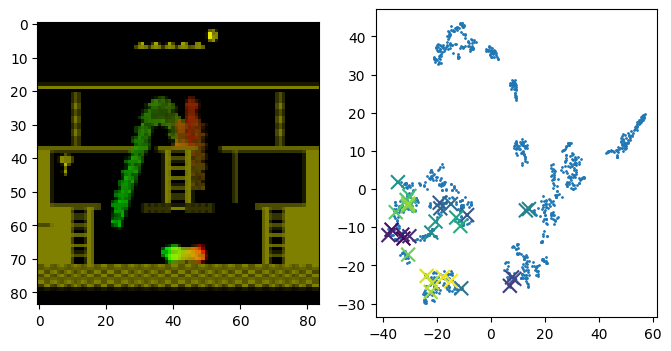

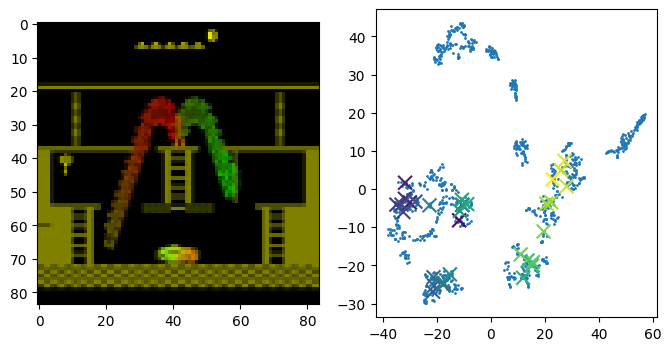

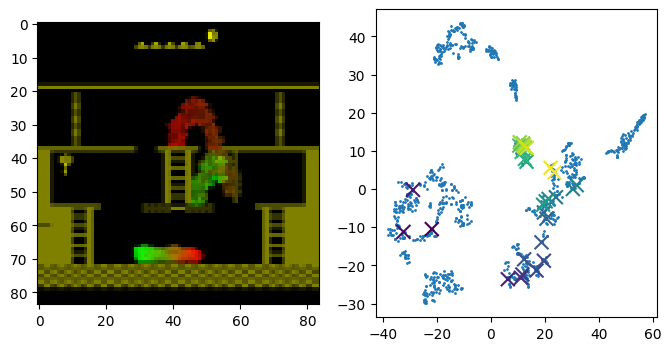

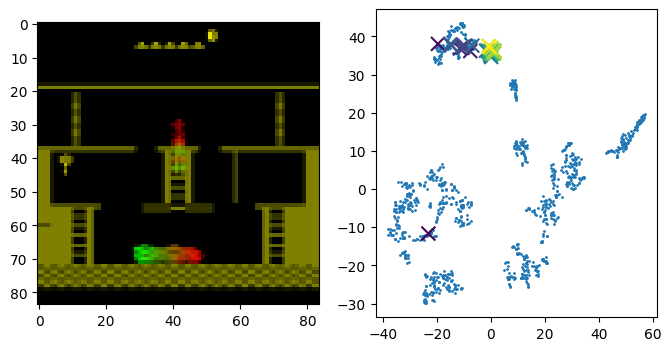

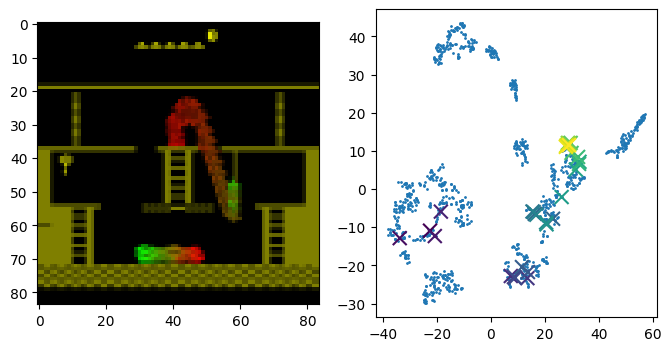

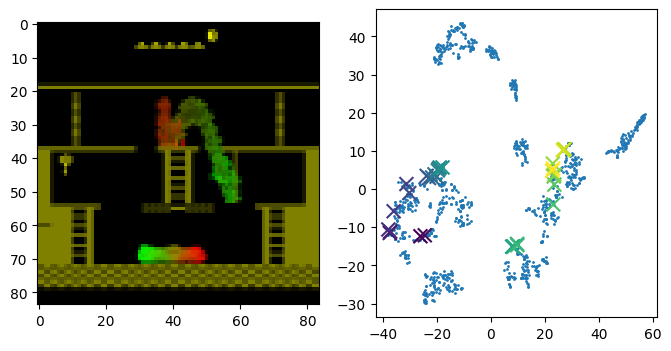

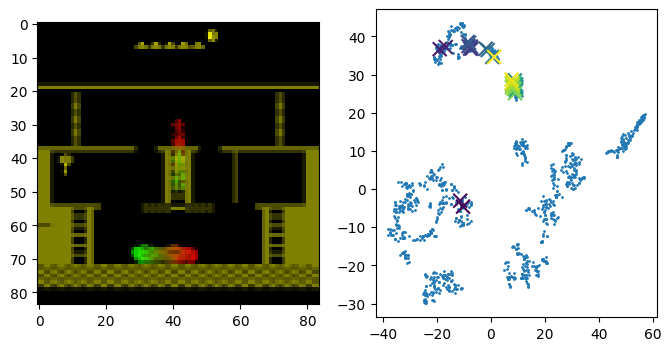

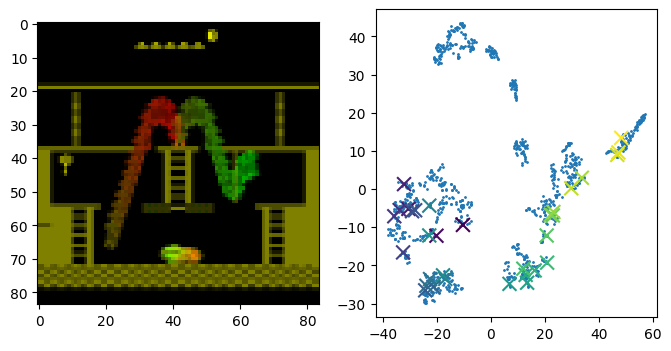

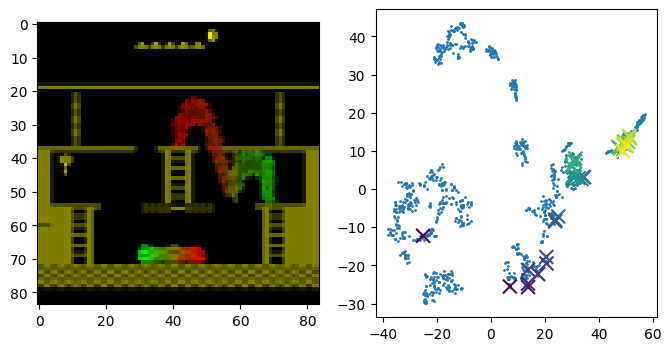

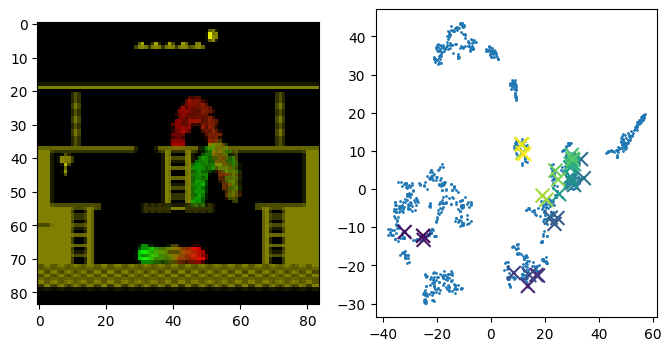

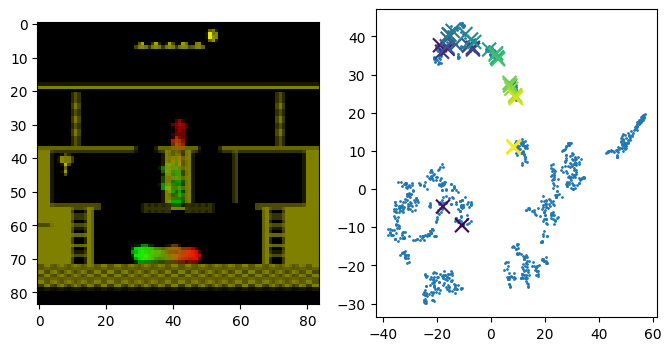

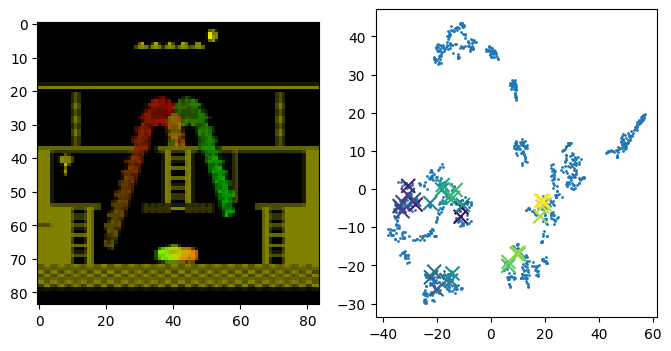

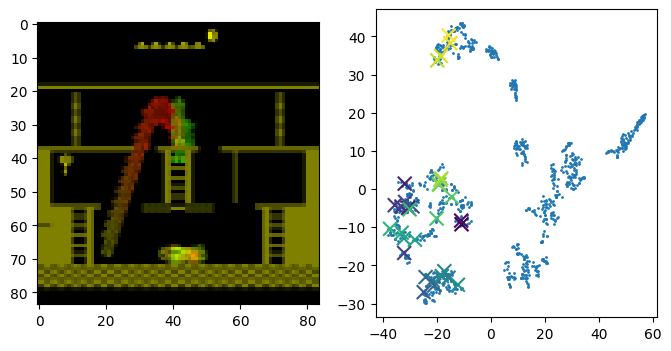

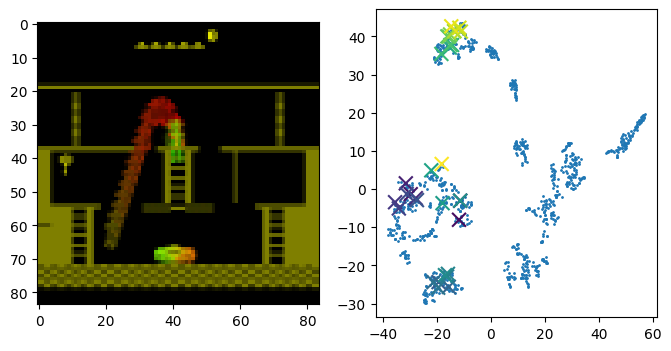

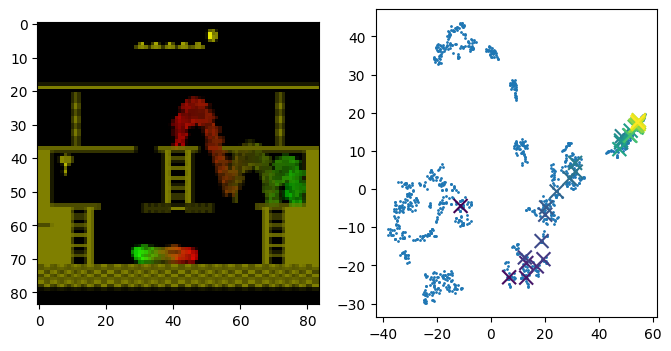

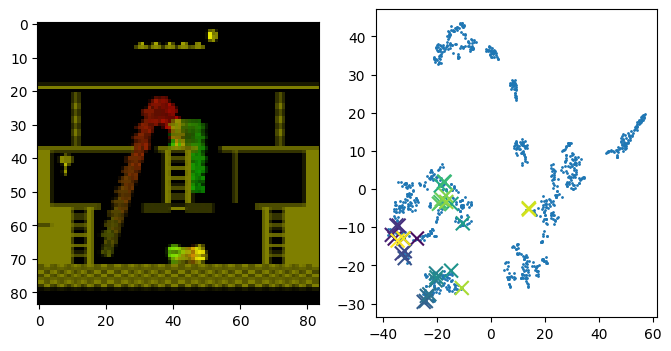

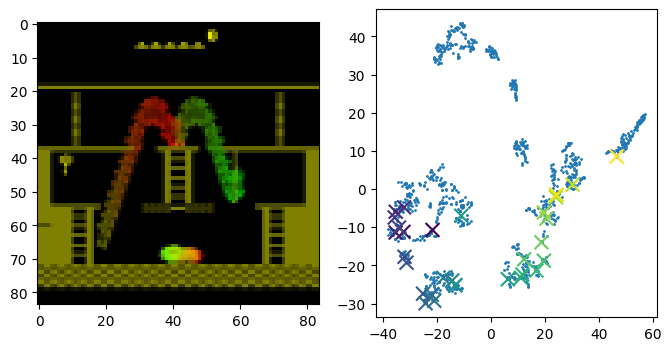

In [123]:
for i in range(32):
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(img[i])
    plt.subplot(122)
    plt.scatter(*X2D.reshape(-1, 2).T, s=1.)
    plt.scatter(*X2D[:, i].T, s=100., marker='x', c=np.arange(32))
    plt.show()

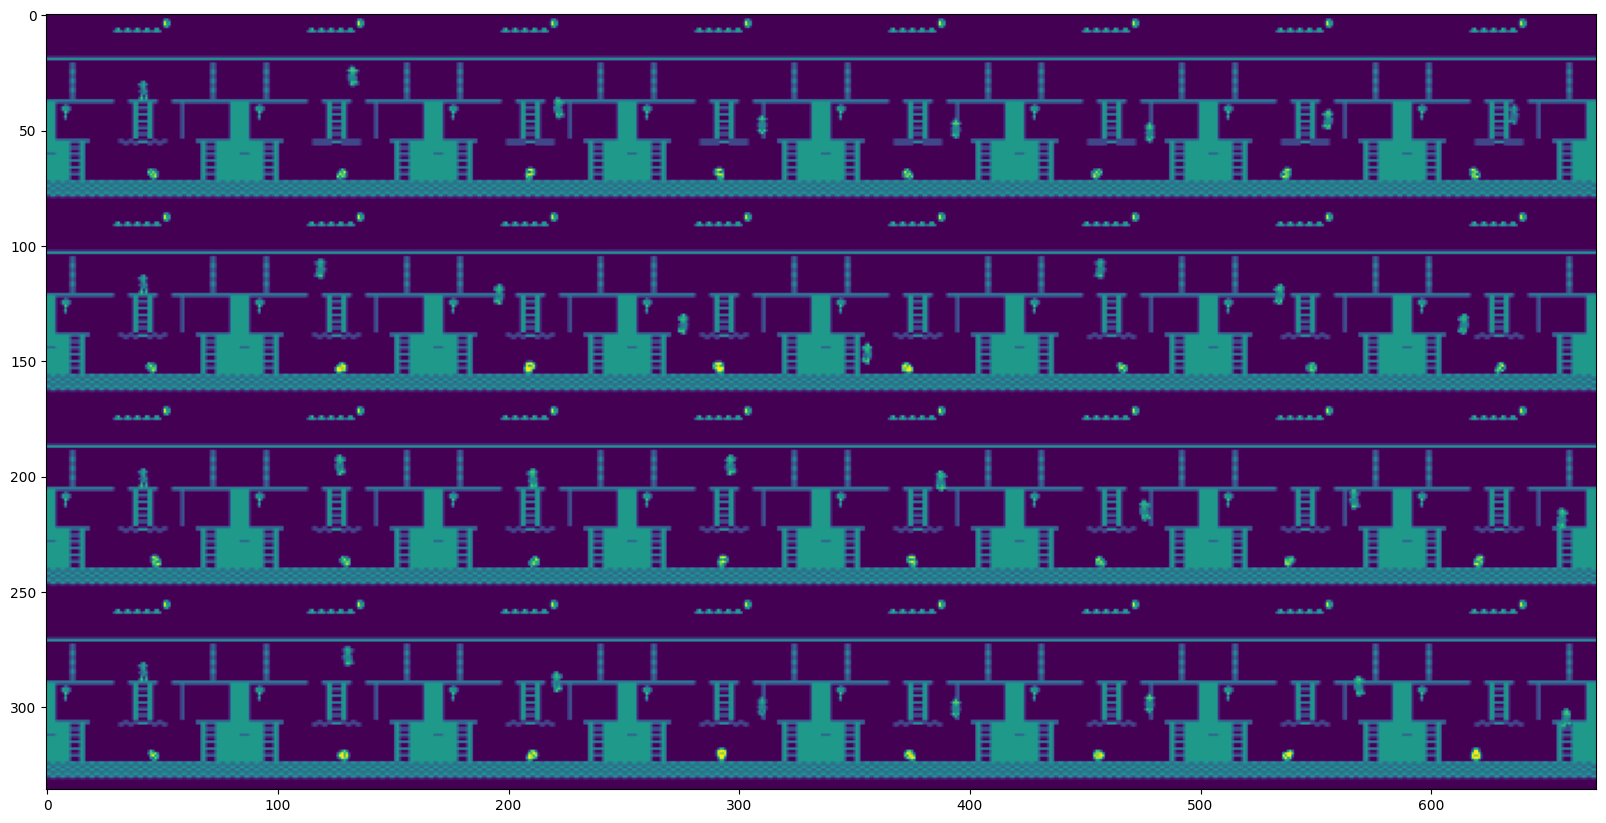

In [43]:
plt.figure(figsize=(20, 20))
plt.imshow(rearrange(o[::4, :4].cpu().numpy(), 't n h w -> (n h) (t w)'))

In [ ]:
plt.figure(figsize=(20, 8))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(o[i].cpu().detach().numpy())
    plt.subplot(2, 5, i + 1 + 5)
    # plt.scatter(X2D[[i], 0], X2D[[i], 1])
    plt.scatter(*X2D.T, s=1.0)
    plt.scatter(*X2D[[i], :].T, s=100.0, c="r", marker="x")
    # plt.xlim(-3, 3); plt.ylim(-3, 3)
plt.tight_layout()
plt.show()